In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

df_bc = pd.DataFrame(X, columns=cancer.feature_names)
df_bc["label"] = y
df_bc.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [2]:
from typing import Tuple, Dict

def fit_predict(model, Xtr, ytr, Xte):
    """Ajusta y predice. Devuelve y_pred."""
    model.fit(Xtr, ytr)
    return model.predict(Xte)

def metrics_dict(y_true, y_pred) -> Dict[str, float]:
    """Calcula métricas básicas en un dict compacto."""
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "accuracy": acc, "precision": pre, "recall": rec, "f1": f1,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    }

def show_cm(y_true, y_pred, title="Confusion matrix", normalize=False):
    """
    Dibuja la matriz de confusión con matplotlib puro.
    Si normalize=True, muestra proporciones por fila.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["Neg", "Pos"]); ax.set_yticklabels(["Neg", "Pos"])

    # etiquetas numéricas
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def print_report(name, mdict):
    """Imprime métricas en formato breve."""
    print(f"\n[{name}] "
          f"ACC={mdict['accuracy']:.4f} "
          f"PRE={mdict['precision']:.4f} "
          f"REC={mdict['recall']:.4f} "
          f"F1={mdict['f1']:.4f} "
          f"| TP={mdict['TP']} FP={mdict['FP']} FN={mdict['FN']} TN={mdict['TN']}")



[RF-80trees] ACC=0.9580 PRE=0.9667 REC=0.9667 F1=0.9667 | TP=87 FP=3 FN=3 TN=50


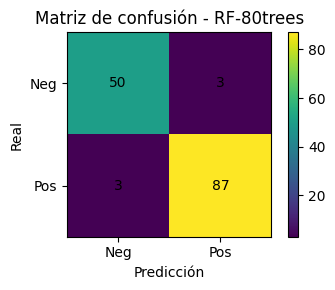


[LogReg-l2] ACC=0.9790 PRE=0.9888 REC=0.9778 F1=0.9832 | TP=88 FP=1 FN=2 TN=52


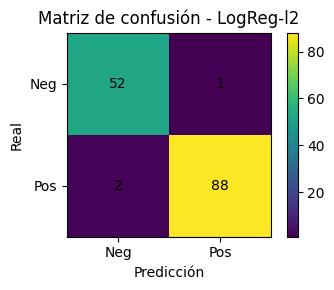


[SVM-linear] ACC=0.9720 PRE=0.9886 REC=0.9667 F1=0.9775 | TP=87 FP=1 FN=3 TN=52


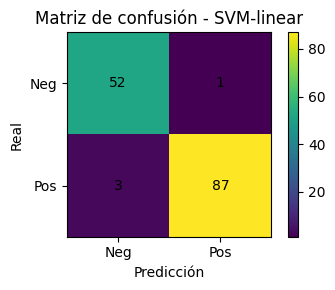

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=7
)

modelos = {
    "RF-80trees": RandomForestClassifier(
        n_estimators=80, random_state=7, n_jobs=-1
    ),
    "LogReg-l2": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, C=1.0, random_state=7)
    ),
    "SVM-linear": make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", C=1.0, random_state=7)
    ),
}

resultados = {}
for nombre, mdl in modelos.items():
    y_hat = fit_predict(mdl, X_tr, y_tr, X_te)
    m = metrics_dict(y_te, y_hat)
    resultados[nombre] = m
    print_report(nombre, m)
    show_cm(y_te, y_hat, title=f"Matriz de confusión - {nombre}", normalize=False)


In [4]:
import pandas as pd

cols = ["accuracy", "precision", "recall", "f1", "TP", "FP", "FN", "TN"]
df_res = pd.DataFrame.from_dict(resultados, orient="index")[cols].sort_values("f1", ascending=False)
print(df_res)


            accuracy  precision    recall        f1  TP  FP  FN  TN
LogReg-l2   0.979021   0.988764  0.977778  0.983240  88   1   2  52
SVM-linear  0.972028   0.988636  0.966667  0.977528  87   1   3  52
RF-80trees  0.958042   0.966667  0.966667  0.966667  87   3   3  50


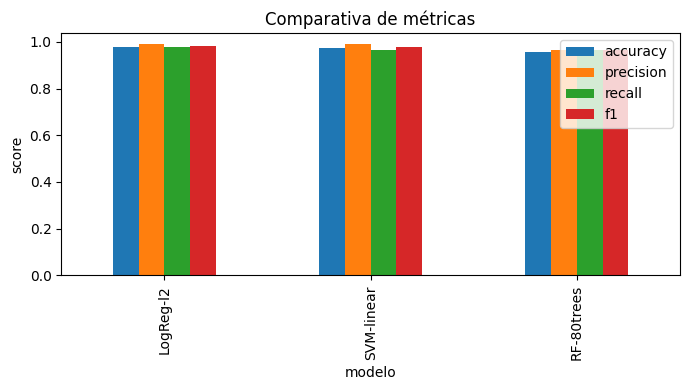

In [5]:
import matplotlib.pyplot as plt

metricas = ["accuracy", "precision", "recall", "f1"]
ax = df_res[metricas].plot(kind="bar", figsize=(7,4))
ax.set_ylabel("score")
ax.set_xlabel("modelo")
ax.set_title("Comparativa de métricas")
plt.tight_layout()
plt.show()
